# Step 0.1. Import necessary libraries 

In [1]:
# Standard python libraries
import logging
import os
import time
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, median_absolute_error
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

#import benchmark.benchmark.benchmark as benchmark - private library

from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS

In [2]:
def dict_to_str(d):
    s = ''
    for key, value in d.items():
        s += f'_{key}:{value}'
    return s

In [3]:
result = pd.read_csv('benchmark/benchmark/benchmark_data.csv', index_col='Unnamed: 0')

In [4]:
PATH = 'ts_example_anon/all_anonimized'

STEP = 7
PLOT = True
params0 = {'trend': False}
params1 = {'trend': True, 'use_rolling': True, 'rolling_size': 7, 'trend_size': 7}
params2 = {'trend': True, 'use_rolling': False, 'rolling_size': 7, 'trend_size': 7}

seq_params = {'seq0': {'case': 'next_values', 
                           'params': {'n_target': STEP,
                                      'history': np.maximum(7, STEP),
                                      'step': 1, 'from_last': True}},}

multi:reg isn`t supported in lgb


I0906 23:31:21.714395 139761944901440 utils.py:129] Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0906 23:31:21.715410 139761944901440 utils.py:141] NumExpr defaulting to 8 threads.
I0906 23:31:21.731465 139761944901440 base.py:220] Layer 1 train process start. Time left 9999999999.99 secs
I0906 23:31:21.776378 139761944901440 base.py:251] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
I0906 23:31:21.778324 139761944901440 base.py:252] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0}
I0906 23:31:21.787899 139761944901440 base.py:281] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn ==

MAE: 0.1483


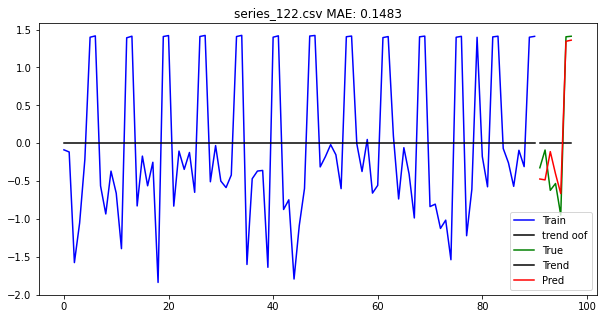

multi:reg isn`t supported in lgb


I0906 23:31:24.546047 139761944901440 cb.py:194] CatBoost supports only MultiRMSE metric and loss for multi:reg task.
I0906 23:31:24.567635 139761944901440 base.py:220] Layer 1 train process start. Time left 9999999999.99 secs
I0906 23:31:24.573204 139761944901440 base.py:251] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
I0906 23:31:24.575705 139761944901440 base.py:252] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 1}
I0906 23:31:24.576760 139761944901440 base.py:281] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
I0906 23:31:24.608126 139761944901440 linear_model.py:408] Linear model: C = 1e-05 score = -0.5395136884044811
I0906 23:31:24.616713 139761944901440 linear_model.py:408] Linear model: C = 5e-05 score = -0.5395136884044811
I0906 23:31:24.626598 

MAE: 0.3328


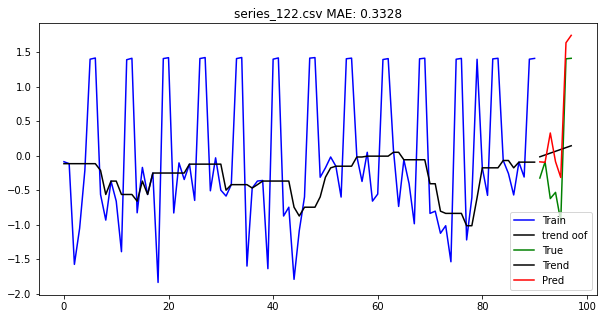

multi:reg isn`t supported in lgb


I0906 23:31:27.165939 139761944901440 cb.py:194] CatBoost supports only MultiRMSE metric and loss for multi:reg task.
I0906 23:31:27.175882 139761944901440 base.py:220] Layer 1 train process start. Time left 9999999999.99 secs
I0906 23:31:27.180818 139761944901440 base.py:251] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
I0906 23:31:27.182794 139761944901440 base.py:252] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 1}
I0906 23:31:27.183649 139761944901440 base.py:281] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
I0906 23:31:27.213804 139761944901440 linear_model.py:408] Linear model: C = 1e-05 score = -0.9367410965456956
I0906 23:31:27.228790 139761944901440 linear_model.py:408] Linear model: C = 5e-05 score = -0.9367771524967105
I0906 23:31:27.245839 

MAE: 0.1487


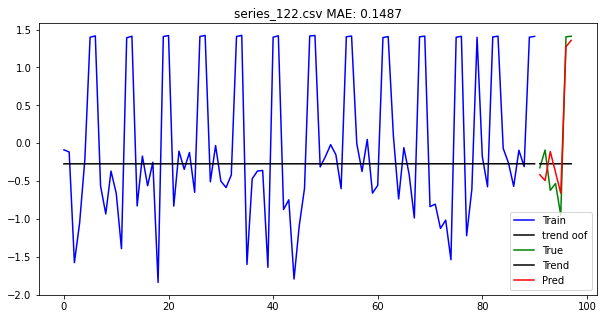

In [5]:
for params in [params0, params1, params2]:
    NAME = dict_to_str(params)
    i = 0
    for seq in tqdm(os.listdir(PATH)):
        cur_path = os.path.join(PATH, seq)
        df = pd.read_csv(cur_path)
        df = df.rename(columns={'Unnamed: 0': 'date', seq.split('.')[0]: 'signal'})

        train = df.iloc[:-STEP].copy()
        test = df.iloc[-STEP:].copy()

        roles = {'target': 'signal'}
        task = Task('multi:reg', greater_is_better=False, metric='mae', loss='mae')
        model = AutoTS(task, seq_params=seq_params, params=params)

        oof_pred_seq, median = model.fit_predict(train, roles)
        pred, trend = model.predict(train, median, test[['date']])
        print(f'MAE: {np.round(median_absolute_error(test.signal.values[-STEP:], pred), 4)}')
        
        if PLOT:
            plt.figure(figsize=[10, 5])
            plt.plot(train.signal.values.tolist() + [np.NaN]*len(test), c='b', label='Train')
            plt.plot(median.tolist() + [np.NaN]*len(test), c='k', label='trend oof')
            plt.plot([np.NaN]*len(train) + test.signal.values[-STEP:].tolist(), c='g', label='True')
            plt.plot([np.NaN]*len(train) + trend.tolist(), c='k',label='Trend')
            plt.plot([np.NaN]*len(train) + pred.tolist(), c='r', label='Pred')
            plt.title(f'{seq} MAE: {np.round(median_absolute_error(test.signal.values[-STEP:], pred), 4)}')
            plt.legend()
            plt.show()
        print('=============')

        naive = [train.signal.values[-1]] * 7
        fact = test.signal.values[-STEP:]
        std = train.signal.std()


        #result.loc[i, f'model{NAME}'] = benchmark.mae_norm(pred, fact, std)
        #result.loc[i, 'fair_naive'] = benchmark.mae_norm(naive, fact, std)
        #result.loc[i, f'trend{NAME}'] = benchmark.mae_norm(trend, fact, std)
        i+=1
        break
        
    #result.to_csv('bench_with_lama.csv', index=False)